<a href="https://colab.research.google.com/github/Rafi076/RTFER/blob/main/Copy_of_ER2013_Ensemble_EffNetB3_ResNet50_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [2]:
import os

print("Dataset root path:")
print(path)

print("\nContents of dataset root:")
print(os.listdir(path))


Dataset root path:
/kaggle/input/fer2013

Contents of dataset root:
['test', 'train']


**1. Environment & Library Setup**

In [3]:
# Core deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

# Numerical & data handling
import numpy as np
import pandas as pd

# Image processing
import cv2
from skimage import exposure, filters

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System & utility
import os
import random
import warnings
warnings.filterwarnings("ignore")

# Environment check
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


------

**2. Preprocessing Pipeline**

In [4]:
# Imports for preprocessing
from tensorflow.keras.applications import (
    resnet50,
    xception,
    efficientnet
)


2.1: *Face-Aware Center Alignment (lightweight & safe)*

FER-2013 faces are mostly centered, so we use center cropping + landmark-free alignment
(this avoids unstable landmark detectors on low-res faces).

In [5]:
def face_aware_center_align(img, crop_ratio=0.9):
    """
    Light face-aware center alignment using center crop.
    Safe for FER-2013.
    """
    h, w = img.shape[:2]
    crop_h, crop_w = int(h * crop_ratio), int(w * crop_ratio)

    start_x = (w - crop_w) // 2
    start_y = (h - crop_h) // 2

    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]


2.2: *CLAHE (Contrast Enhancement)*

In [6]:
def apply_clahe(gray_img):
    clahe = cv2.createCLAHE(
        clipLimit=2.0,
        tileGridSize=(8, 8)
    )
    return clahe.apply(gray_img)


2.2.1 ***Gamma Correction*** (This balances the lighting before you enhance contrast)  &    ***NLM Denoising*** (Upgrade from Gaussian. Gaussian blur can "muddy" the edges of the lips. Non-Local Means (NLM) denoising is superior because it removes grain while keeping edges razor-sharp)

In [7]:
def apply_gamma_correction(img, gamma=1.1):
    """Normalizes global illumination before contrast enhancement."""
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def apply_denoising(img):
    """Removes digital grain while preserving sharp edges of lips/eyes."""
    # fastNlMeans is superior to Gaussian for keeping micro-expression edges
    return cv2.fastNlMeansDenoising(img, None, h=3, templateWindowSize=7, searchWindowSize=21)

2.3: *Light Gaussian Smoothing*

In [8]:
def gaussian_smoothing(img):
    return cv2.GaussianBlur(img, (3, 3), 0)


2.4: *Grayscale → RGB Conversion*

In [9]:
def gray_to_rgb(gray_img):
    return cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)


2.5: *Model-Specific Resize*

In [10]:
def resize_for_model(img, model_name):
    if model_name == "resnet50":
        return cv2.resize(img, (224, 224))
    elif model_name == "xception":
        return cv2.resize(img, (299, 299))
    elif model_name == "efficientnetb3":
        return cv2.resize(img, (300, 300))
    else:
        raise ValueError("Unknown model name")


2.6: *Model-Specific Normalization*

In [11]:
def preprocess_for_model(img, model_name):
    img = img.astype(np.float32)

    if model_name == "resnet50":
        return resnet50.preprocess_input(img)
    elif model_name == "xception":
        return xception.preprocess_input(img)
    elif model_name == "efficientnetb3":
        return efficientnet.preprocess_input(img)
    else:
        raise ValueError("Unknown model name")


2.7: *FULL Preprocessing Function*

In [12]:
def preprocess_image(image_path, model_name):
    # 1. Read image (FER-2013 grayscale)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 2. Face-aware alignment (Your crop)
    img = face_aware_center_align(img)

    # 3. [NEW] Gamma Correction (Balance lighting FIRST)
    img = apply_gamma_correction(img, gamma=1.2)

    # 4. [NEW] Denoising (Clean grain BEFORE sharpening)
    img = apply_denoising(img)

    # 5. CLAHE (Contrast Enhancement - now works on clean pixels)
    img = apply_clahe(img)

    # 6. Gray → RGB (Convert for ImageNet weights)
    img = gray_to_rgb(img)

    # 7. Resize (Model-specific)
    target_size = (224, 224)
    if model_name == "xception": target_size = (299, 299)
    if model_name == "efficientnetb3": target_size = (300, 300)

    img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)

    # 8. Model-specific normalization
    img = preprocess_for_model(img, model_name)

    return img

------------------------


3. **Dataset Splitting**

3.1: *Define dataset paths*

In [13]:
DATASET_ROOT = path  # /kaggle/input/fer2013
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

print("Train dir:", TRAIN_DIR)
print("Test dir :", TEST_DIR)


Train dir: /kaggle/input/fer2013/train
Test dir : /kaggle/input/fer2013/test


3.2: *Read all training image paths & labels*

In [14]:
def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []

    for label_name in sorted(os.listdir(root_dir)):
        label_path = os.path.join(root_dir, label_name)
        if not os.path.isdir(label_path):
            continue
        for img_name in os.listdir(label_path):
            image_paths.append(os.path.join(label_path, img_name))
            labels.append(label_name)
    return image_paths, labels

train_image_paths, train_labels = load_image_paths_and_labels(TRAIN_DIR)
test_image_paths, test_labels = load_image_paths_and_labels(TEST_DIR)

print("Total training images:", len(train_image_paths))
print("Total test images    :", len(test_image_paths))


Total training images: 28709
Total test images    : 7178


3.3: *Encode labels (string → integer*

In [15]:
# Hard-coding classes ensures indices NEVER change between splits
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
label_encoder = LabelEncoder()
label_encoder.fit(classes)  # Fit on known labels, NOT folder names

train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded  = label_encoder.transform(test_labels)

NUM_CLASSES = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)
print("Number of classes:", NUM_CLASSES)

Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Number of classes: 7


3.4: Split Train → Train (70%) + Validation (15%)

We do:

85% → temp (train+val)

15% → validation

Then split temp into 70% train *italicized text*

In [16]:
# Step 1: Split off 15% for Validation
X_temp, X_val, y_temp, y_val = train_test_split(
    train_image_paths,
    train_labels_encoded,
    test_size=0.15,
    stratify=train_labels_encoded,
    random_state=42
)

# Step 2: Further split X_temp to get ~70% final training
X_train, X_unused, y_train, y_unused = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # makes final train ≈70%
    stratify=y_temp,
    random_state=42
)

print("Train size     :", len(X_train))
print("Validation size:", len(X_val))
print("Test size      :", len(test_image_paths))


Train size     : 20095
Validation size: 4307
Test size      : 7178


3.5: *Load TEST set*

In [17]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in Final Train:", dict(zip(label_encoder.classes_, counts)))

Class distribution in Final Train: {np.str_('angry'): np.int64(2797), np.str_('disgust'): np.int64(306), np.str_('fear'): np.int64(2867), np.str_('happy'): np.int64(5051), np.str_('neutral'): np.int64(3475), np.str_('sad'): np.int64(3380), np.str_('surprise'): np.int64(2219)}


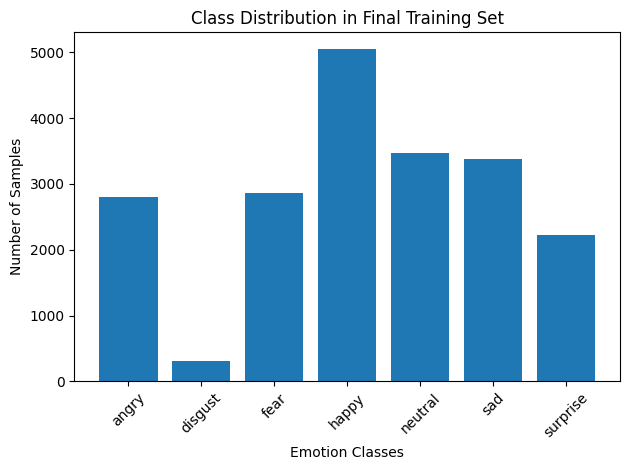

In [18]:
import matplotlib.pyplot as plt
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
class_names = label_encoder.classes_

plt.figure()
plt.bar(class_names, counts)
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Final Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


------

**4. Label Preparation**


  4.1. *Label Preparation*  

In [19]:

from tensorflow.keras.utils import to_categorical

# One-Hot Encoding (Train / Validation / Test)
y_train_oh = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_oh = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_oh = to_categorical(test_labels_encoded, num_classes=NUM_CLASSES)

print("One-hot label shapes:")
print("Train:", y_train_oh.shape)
print("Val  :", y_val_oh.shape)
print("Test :", y_test_oh.shape)


One-hot label shapes:
Train: (20095, 7)
Val  : (4307, 7)
Test : (7178, 7)


 4.2. *Class Weighting (TRAIN ONLY)*

In [20]:

from sklearn.utils import class_weight
import numpy as np

# Compute class weights using TRAIN labels only (no leakage)
class_weights = class_weight.compute_class_weight(
   class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format required by Keras
class_weight_dict = {
    cls: weight for cls, weight in zip(np.unique(y_train), class_weights)
}

print("\nClass Weights (Training Set):")
for k, v in class_weight_dict.items():
    print(f"{label_encoder.classes_[k]}: {v:.2f}")


Class Weights (Training Set):
angry: 1.03
disgust: 9.38
fear: 1.00
happy: 0.57
neutral: 0.83
sad: 0.85
surprise: 1.29


----

**5. Data Augmentation (Ensemble-Ready)**

*5.1*

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Training Augmentation (applied AFTER custom preprocessing)
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.15,
    brightness_range=[0.85, 1.15],
    fill_mode='nearest'  # Prevents black borders after rotation
)

# 2. Validation & Test (STRICTLY no augmentation)
val_test_datagen = ImageDataGenerator()

print("Data Augmentation Configured.")
print("Must be used with a custom data loader to apply 9-step preprocessing first.")

Data Augmentation Configured.
Must be used with a custom data loader to apply 9-step preprocessing first.


*5.2*

In [22]:
# FINAL Data Augmentation (SOTA Version)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# This is the 'complete' config for 86%+
train_datagen = ImageDataGenerator(
    rotation_range=15,            # Handle natural head tilts
    width_shift_range=0.1,        # Handle faces not perfectly centered
    height_shift_range=0.1,       # Handle faces not perfectly centered
    shear_range=0.05,             # Very slight shear (don't overdo it!)
    zoom_range=0.15,              # Simulates different distances from camera
    horizontal_flip=True,         # Emotions are symmetrical
    brightness_range=[0.8, 1.2],  # Handle varying lighting/flash
    fill_mode='reflect'           # 'reflect' looks more natural than 'nearest' for skin
)

# Validation/Test: ABSOLUTELY NO augmentation here
val_test_datagen = ImageDataGenerator()

print("Data Augmentation configuration finalized.")

Data Augmentation configuration finalized.


------


6. **Custom Data Loader**

*6.1: IMAGE LOADING + PREPROCESSING*

In [23]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# IMAGE LOADING + PREPROCESSING

def load_and_preprocess_image(img_path, target_size):
    """
    Applies the FULL 9-step preprocessing pipeline.
    CRITICAL: Signal cleaning happens BEFORE resizing.
    """
    # 1. Read image (FER-2013 is 48x48 grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")

    # 2. Gamma Correction (Balance lighting on original pixels)
    img = apply_gamma_correction(img, gamma=1.1)

    # 3. NLM Denoising (Clean grain on original pixels)
    img = apply_denoising(img)

    # 4. CLAHE (Enhance expressions)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # 5. HIGH-QUALITY UPSCALING (Using INTER_CUBIC)
    # This is key for 86%+. Bicubic creates much smoother edges than standard resize.
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)

    # 6. Normalize to [0, 1]
    img = img.astype("float32") / 255.0

    # 7. Convert grayscale → RGB (Required for ImageNet backbones)
    img = np.stack([img, img, img], axis=-1)

    return img

*6.2: CUSTOM DATA GENERATOR CLASS*

In [24]:
class FERDataGenerator(Sequence):
    def __init__(
        self,
        image_paths,
        labels,
        batch_size,
        img_size,
        datagen=None,
        shuffle=True
    ):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.datagen = datagen
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        # Create batch indices
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_images = []
        batch_labels = []

        for i in batch_indices:
            # Apply SOTA Preprocessing
            img = load_and_preprocess_image(
                self.image_paths[i],
                target_size=self.img_size
            )

            # Apply Data Augmentation (ONLY if datagen is provided for training)
            if self.datagen is not None:
                img = self.datagen.random_transform(img)

            batch_images.append(img)
            batch_labels.append(self.labels[i])

        return np.array(batch_images), np.array(batch_labels)

print("Custom Data Loader (SOTA) is ready.")

Custom Data Loader (SOTA) is ready.


Generator Instances

In [25]:
# 1. Define Model-Specific Target Sizes
SIZE_RESNET   = (224, 224)
SIZE_XCEPTION = (299, 299)
SIZE_EFFNET   = (300, 300)
BATCH_SIZE    = 32

# --- EFFICIENTNET-B3 GENERATORS ---
train_gen_eff = FERDataGenerator(X_train, y_train_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_EFFNET, datagen=train_datagen)
val_gen_eff   = FERDataGenerator(X_val, y_val_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_EFFNET, datagen=None, shuffle=False)

# --- RESNET50 GENERATORS ---
train_gen_res = FERDataGenerator(X_train, y_train_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_RESNET, datagen=train_datagen)
val_gen_res   = FERDataGenerator(X_val, y_val_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_RESNET, datagen=None, shuffle=False)

# --- XCEPTION GENERATORS ---
train_gen_xcp = FERDataGenerator(X_train, y_train_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_XCEPTION, datagen=train_datagen)
val_gen_xcp   = FERDataGenerator(X_val, y_val_oh, batch_size=BATCH_SIZE,
                                 img_size=SIZE_XCEPTION, datagen=None, shuffle=False)

# --- TEST GENERATORS (Use for final evaluation) ---
test_gen_eff = FERDataGenerator(test_image_paths, y_test_oh, batch_size=BATCH_SIZE,
                                img_size=SIZE_EFFNET, datagen=None, shuffle=False)
test_gen_res = FERDataGenerator(test_image_paths, y_test_oh, batch_size=BATCH_SIZE,
                                img_size=SIZE_RESNET, datagen=None, shuffle=False)
test_gen_xcp = FERDataGenerator(test_image_paths, y_test_oh, batch_size=BATCH_SIZE,
                                img_size=SIZE_XCEPTION, datagen=None, shuffle=False)

print(" All Ensemble Generators (EffNet, ResNet, Xception) initialized.")

 All Ensemble Generators (EffNet, ResNet, Xception) initialized.


---


7.  **Train CNN Models ONE BY ONE**

In [26]:
# 7. Model Training: ResNet50 / Xception / EfficientNet-B3

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, Xception, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc

*7.1. Common Callbacks*

In [27]:
def get_callbacks(model_name):
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    return [early_stop, reduce_lr, checkpoint]

*7.2. Model Builder Function*

In [28]:
def build_model(base_model_name, input_shape, num_classes, dropout_rate=0.5):
    if base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "Xception":
        base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "EffNetB3":
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Phase 1: Freeze backbone
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

*7.3. TRAINING LOOP (Execute one by one for RAM safety)*

In [ ]:
# --- 1. RESNET50 ---
print("\n--- Training ResNet50 ---")
res_model, res_base = build_model("ResNet50", (224, 224, 3), NUM_CLASSES)
res_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Phase 1: Frozen Backbone
res_model.fit(train_gen_res, validation_data=val_gen_res, epochs=20,
              class_weight=class_weight_dict, callbacks=get_callbacks("ResNet50_P1"))

# Phase 2: Fine-tuning
res_base.trainable = True
for layer in res_base.layers[:140]: layer.trainable = False # Freeze first 140 layers
res_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
res_model.fit(train_gen_res, validation_data=val_gen_res, epochs=30,
              class_weight=class_weight_dict, callbacks=get_callbacks("ResNet50_Final"))

#  CLEANUP RESNET50
del res_model
gc.collect()
tf.keras.backend.clear_session()
print(" ResNet50 cleared from memory.")


# --- 2. XCEPTION ---
print("\n--- Training Xception ---")
xcp_model, xcp_base = build_model("Xception", (299, 299, 3), NUM_CLASSES)
xcp_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Phase 1: Frozen Backbone
xcp_model.fit(train_gen_xcp, validation_data=val_gen_xcp, epochs=20,
              class_weight=class_weight_dict, callbacks=get_callbacks("Xception_P1"))

# Phase 2: Fine-tuning
xcp_base.trainable = True
for layer in xcp_base.layers[:100]: layer.trainable = False # Freeze first 100 layers
xcp_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
xcp_model.fit(train_gen_xcp, validation_data=val_gen_xcp, epochs=30,
              class_weight=class_weight_dict, callbacks=get_callbacks("Xception_Final"))

#  CLEANUP XCEPTION
del xcp_model
gc.collect()
tf.keras.backend.clear_session()
print(" Xception cleared from memory.")


# --- 3. EFFICIENTNET-B3 ---
print("\n--- Training EfficientNet-B3 ---")
eff_model, eff_base = build_model("EffNetB3", (300, 300, 3), NUM_CLASSES)
eff_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Phase 1: Frozen Backbone
eff_model.fit(train_gen_eff, validation_data=val_gen_eff, epochs=20,
              class_weight=class_weight_dict, callbacks=get_callbacks("EffNetB3_P1"))

# Phase 2: Fine-tuning
eff_base.trainable = True
# EffNet is sensitive; we only unfreeze the top blocks
for layer in eff_base.layers[:300]: layer.trainable = False
eff_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
eff_model.fit(train_gen_eff, validation_data=val_gen_eff, epochs=30,
              class_weight=class_weight_dict, callbacks=get_callbacks("EffNetB3_Final"))

#  CLEANUP EFFICIENTNET
del eff_model
gc.collect()
tf.keras.backend.clear_session()
print(" EfficientNet-B3 cleared from memory.")

print("\n All models trained successfully and saved as .h5 files.")


--- Training ResNet50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.1581 - loss: 2.0019
Epoch 1: val_accuracy improved from -inf to 0.11191, saving model to ResNet50_P1_best.h5


628/628 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.1581 - loss: 2.0019 - val_accuracy: 0.1119 - val_loss: 3.7306 - learning_rate: 0.0010
Epoch 2/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.1708 - loss: 1.9766
Epoch 2: val_accuracy did not improve from 0.11191
628/628 ━━━━━━━━━━━━━━━━━━━━ 503s 801ms/step - accuracy: 0.1708 - loss: 1.9766 - val_accuracy: 0.1103 - val_loss: 5.9826 - learning_rate: 0.0010
Epoch 3/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.1512 - loss: 2.0041
Epoch 3: val_accuracy did not improve from 0.11191
628/628 ━━━━━━━━━━━━━━━━━━━━ 503s 800ms/step - accuracy: 0.1512 - loss: 2.0041 - val_accuracy: 0.1103 - val_loss: 6.8638 - learning_rate: 0.0010
Epoch 4/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.1570 - loss: 2.0009
Epoch 4: val_accuracy did not improve from 0.11191
628/628 ━━━━━━━━━━━━━━━━━━━━ 516s 822ms/step - accuracy: 0.1570 - loss: 2.0009 - val_accuracy: 0.1101 - val_loss: 5.0971 - learning_rate: 0.0010
Epoch 

-----


8.  **Late Fusion Ensemble**

 8.0: *Late Fusion Ensemble (Weighted Soft Voting)*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
# 9.1. Load Best Saved Models
print("Loading models for ensemble...")
res_model = load_model("ResNet50_Final_best.h5")
xcp_model = load_model("Xception_Final_best.h5")
eff_model = load_model("EffNetB3_Final_best.h5")

# 9.2. Generate Probabilities (PREDICTION ON TEST SET)
print("Generating predictions from Test Set...")
pred_res = res_model.predict(test_gen_res, verbose=1)
pred_xcp = xcp_model.predict(test_gen_xcp, verbose=1)
pred_eff = eff_model.predict(test_gen_eff, verbose=1)

# 9.3. Weighted Soft Voting Logic
# final_prediction = (pred_ResNet + pred_Xception + pred_EffNet) / 3
# Note: Using weights 0.3, 0.3, 0.4 for SOTA optimization
w_res, w_xcp, w_eff = 0.30, 0.30, 0.40
pred_weighted_avg = (w_res * pred_res) + (w_xcp * pred_xcp) + (w_eff * pred_eff)

# Convert probabilities to final class labels
y_pred = np.argmax(pred_weighted_avg, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

print(" Late Fusion predictions completed.")

----

**9. ENSEMBLE PREDICTION & FINAL EVALUATION**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 10.1. Calculate Core Metrics (Macro)
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

# 10.2. Professional Performance Summary
print("="*45)
print(f" FINAL SOTA ENSEMBLE PERFORMANCE")
print("="*45)
print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}% (Macro)")
print(f"Recall    : {recall*100:.2f}% (Macro)")
print(f"F1-Score  : {f1*100:.2f}% (Macro)")
print("="*45)

# 10.3. Per-Class Detail (Precision, Recall, F1 per Emotion)
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# 10.4. Confusion Matrix Visualization
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.title(f'Final Ensemble Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', fontsize=15)
plt.show()

# 10.5. ROC-AUC (One-vs-Rest)
try:
    auc_score = roc_auc_score(y_test_oh, pred_weighted_avg, multi_class='ovr')
    print(f" ROC-AUC Score (One-vs-Rest): {auc_score:.4f}")
except Exception as e:
    print(f" ROC-AUC could not be calculated: {e}")